In [106]:
import copy
import typing as t
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from torch.utils.data import DataLoader, Dataset, Subset, random_split
from torchvision import transforms
from torchvision.datasets import ImageFolder
from tqdm import tqdm

In [107]:
# @formatter:off
%matplotlib inline
# @formatter:on

In [108]:
torch.set_warn_always(True)

sns.set_theme()
plt.rcParams["figure.figsize"] = (8, 4)

In [109]:
DATA_DIR = Path("../data/")

CUDA = "cuda"
CPU = "cpu"
DEVICE = CUDA if torch.cuda.is_available() else CPU
print(f"Using {DEVICE.upper()} device")

Using CUDA device


## Предобработка данных и подготовка датасета

In [110]:
def preprocess_images(dataset: ImageFolder, save_dir: Path) -> None:
    save_dir.mkdir(exist_ok=True)
    for cls in dataset.classes:
        (save_dir / cls).mkdir(exist_ok=True)

    for i in tqdm(range(len(dataset))):
        img, target = dataset[i]
        img.save(save_dir / dataset.classes[target] / Path(dataset.imgs[i][0]).name)


def show_sample_images(dataset: ImageFolder, cols: int = 3, rows: int = 3) -> None:
    fig, axes = plt.subplots(cols, rows, figsize=(6, 6))
    for i, ax in zip(torch.randperm(len(dataset)), axes.flatten()):
        img, target = dataset[i]
        ax.axis("off")
        ax.set_title(dataset.classes[target], fontdict={"fontsize": 10})
        if img.mode == "RGB":
            ax.imshow(img)
        else:
            ax.imshow(img, cmap="gray")


def torch_train_test_split(dataset: t.Union[Dataset, t.Sized], test_size: float) -> t.Tuple[Subset, Subset]:
    test_size = round(test_size * len(dataset))
    train_size = len(dataset) - test_size
    train_dataset, test_dataset = random_split(dataset, lengths=(train_size, test_size))
    return train_dataset, test_dataset

In [111]:
base_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
])

masks_dataset = ImageFolder(DATA_DIR / "images/masks", transform=base_transform)
save_dataset_dir = DATA_DIR / "images/masks_64"
preprocess_images(masks_dataset, save_dataset_dir)
masks_dataset = ImageFolder(save_dataset_dir)

100%|██████████| 616/616 [00:01<00:00, 467.79it/s]


with_mask       341
without_mask    275
dtype: int64


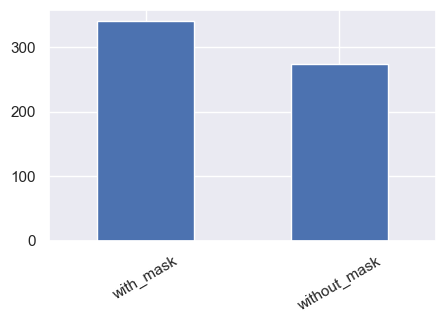

In [112]:
vc = pd.value_counts(masks_dataset.targets)
vc.index = [masks_dataset.classes[i] for i in vc.index]
print(vc)
vc.plot.bar(rot=30, figsize=(5, 3));

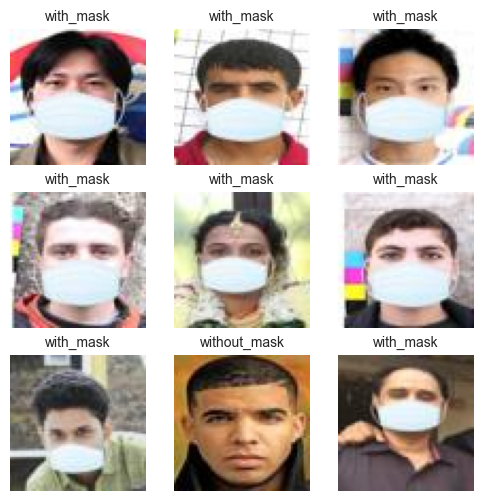

In [113]:
torch.manual_seed(0)
show_sample_images(masks_dataset)

In [114]:
torch.manual_seed(0)

train_transform = transforms.Compose([
    *base_transform.transforms,
    transforms.RandomHorizontalFlip(p=0.25),
    transforms.RandomVerticalFlip(p=0.25),
    transforms.RandomRotation(degrees=(-30, 30)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])
test_transform = transforms.Compose([
    *base_transform.transforms,
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
])

train_dataset, test_dataset = torch_train_test_split(masks_dataset, test_size=0.2)
train_dataset.dataset = copy.deepcopy(train_dataset.dataset)
train_dataset.dataset.transform = train_transform
test_dataset.dataset = copy.deepcopy(test_dataset.dataset)
test_dataset.dataset.transform = test_transform

len(train_dataset), len(test_dataset)

(493, 123)

## Построение и обучение модели

In [115]:
def get_weights(targets: torch.Tensor) -> torch.Tensor:
    _, counts = targets.unique(return_counts=True)
    return counts.max() / counts


def common_train(
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        epochs: int,
        train_dataloader: DataLoader,
        test_dataloader: DataLoader,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[t.List[float], t.List[float], t.List[float], t.List[float]]:
    train_losses, train_accuracy_list = [], []
    test_losses, test_accuracy_list = [], []
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}\n" + "-" * 32)

        train_loss, train_accuracy = train_loop(train_dataloader, model, loss_fn, optimizer, verbose, device)
        print(f"Train Error: loss: {train_loss:.6f}, accuracy: {train_accuracy:.4f}")
        train_losses.append(train_loss)
        train_accuracy_list.append(train_accuracy)

        test_loss, test_accuracy = test_loop(test_dataloader, model, loss_fn, device)
        print(f" Test Error: loss: {test_loss:.6f}, accuracy: {test_accuracy:.4f}\n")
        test_losses.append(test_loss)
        test_accuracy_list.append(test_accuracy)

        torch.cuda.empty_cache()
    return train_losses, train_accuracy_list, test_losses, test_accuracy_list


def train_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        optimizer: optim.Optimizer,
        verbose: int = None,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.train()

    size = len(dataloader.dataset)  # noqa
    num_batches = len(dataloader)
    avg_loss, avg_accuracy = 0, 0

    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)

        pred = model(x)
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        y_true = torch.flatten(y).detach().cpu()
        y_pred = torch.flatten(pred.argmax(1)).detach().cpu()
        accuracy = metrics.accuracy_score(y_true, y_pred)

        avg_loss += loss
        avg_accuracy += accuracy
        if verbose and batch % verbose == 0:
            print(f"[{batch * len(x):>4d}/{size:>4d}]: loss: {loss:.6f}, accuracy: {accuracy:.4f}")

        del x, y, pred, loss
        torch.cuda.empty_cache()

    return (avg_loss / num_batches).item(), avg_accuracy / num_batches


@torch.no_grad()
def test_loop(
        dataloader: DataLoader,
        model: nn.Module,
        loss_fn: nn.Module,
        device: str = CPU,
) -> t.Tuple[float, float]:
    model.eval()
    y_true, y_pred = get_y_true_y_pred(model, dataloader, device)
    return loss_fn(y_pred, y_true).item(), metrics.accuracy_score(y_true.cpu(), y_pred.argmax(1).cpu())


@torch.no_grad()
def get_y_true_y_pred(
        model: nn.Module,
        dataloader: DataLoader,
        device: str = CPU,
) -> t.Tuple[torch.Tensor, torch.Tensor]:
    model.eval()

    y_test = []
    y_pred = []
    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        pred = model(x)
        y_test.append(y.unsqueeze(1))
        y_pred.append(pred)

        del x
        torch.cuda.empty_cache()

    return torch.flatten(torch.vstack(y_test)), torch.vstack(y_pred)


def plot_train_test(
        train_losses: t.List[float],
        train_accuracy: t.List[float],
        test_losses: t.List[float],
        test_accuracy: t.List[float],
) -> None:
    fig, axes = plt.subplots(2, 1, figsize=(6, 7))
    epochs = torch.arange(len(train_losses))

    axes[0].plot(epochs, train_losses)
    axes[0].plot(epochs, test_losses)
    axes[0].set_ylabel("loss")
    axes[0].legend(["train", "test"])

    axes[1].plot(epochs, train_accuracy)
    axes[1].plot(epochs, test_accuracy)
    axes[1].set_xlabel("epoch")
    axes[1].set_ylabel("accuracy")

In [116]:
class MasksClassifier(nn.Module):
    LAST_CONV_OUT_CHANNELS = 64
    ADAPTIVE_AVG_POOL = 4

    def __init__(self, num_channels: int, num_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(True),
            nn.MaxPool2d(2),
            nn.Conv2d(in_channels=32, out_channels=self.LAST_CONV_OUT_CHANNELS, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(self.LAST_CONV_OUT_CHANNELS),
            nn.ReLU(True),
            nn.MaxPool2d(2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((self.ADAPTIVE_AVG_POOL, self.ADAPTIVE_AVG_POOL))
        self.classifier = nn.Linear(
            self.LAST_CONV_OUT_CHANNELS * self.ADAPTIVE_AVG_POOL * self.ADAPTIVE_AVG_POOL,
            num_classes,
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

In [117]:
torch.manual_seed(0)

net = MasksClassifier(
    num_channels=train_dataset[0][0].size(0),
    num_classes=len(masks_dataset.classes),
).to(DEVICE)
weights = get_weights(torch.tensor([target for _, target in train_dataset], device=DEVICE))
loss_fn = nn.CrossEntropyLoss(weight=weights)
optimizer = optim.Adam(net.parameters(), lr=0.001)

train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=2)
test_dataloader = DataLoader(test_dataset, batch_size=len(test_dataset), num_workers=2)

net

MasksClassifier(
  (features): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(4, 4))
  (classifier): Linear(in_features=1024, out_features=2, bias=True)
)

In [118]:
%%time

if __name__ == '__main__':
    train_losses, train_accuracy, test_losses, test_accuracy = common_train(
        epochs=20,
        model=net,
        loss_fn=loss_fn,
        optimizer=optimizer,
        train_dataloader=train_dataloader,
        test_dataloader=test_dataloader,
        device=DEVICE,
    )

Epoch 1
--------------------------------
Train Error: loss: 0.317243, accuracy: 0.8669
 Test Error: loss: 0.375111, accuracy: 0.9106

Epoch 2
--------------------------------
Train Error: loss: 0.180750, accuracy: 0.9516
 Test Error: loss: 0.128829, accuracy: 0.9512

Epoch 3
--------------------------------
Train Error: loss: 0.123497, accuracy: 0.9597
 Test Error: loss: 0.074731, accuracy: 0.9593

Epoch 4
--------------------------------
Train Error: loss: 0.118453, accuracy: 0.9677
 Test Error: loss: 0.085697, accuracy: 0.9593

Epoch 5
--------------------------------
Train Error: loss: 0.136033, accuracy: 0.9597
 Test Error: loss: 0.105486, accuracy: 0.9593

Epoch 6
--------------------------------
Train Error: loss: 0.123942, accuracy: 0.9556
 Test Error: loss: 0.087868, accuracy: 0.9675

Epoch 7
--------------------------------
Train Error: loss: 0.128845, accuracy: 0.9536
 Test Error: loss: 0.095365, accuracy: 0.9756

Epoch 8
--------------------------------
Train Error: loss: 0.

## Оценка и выводы

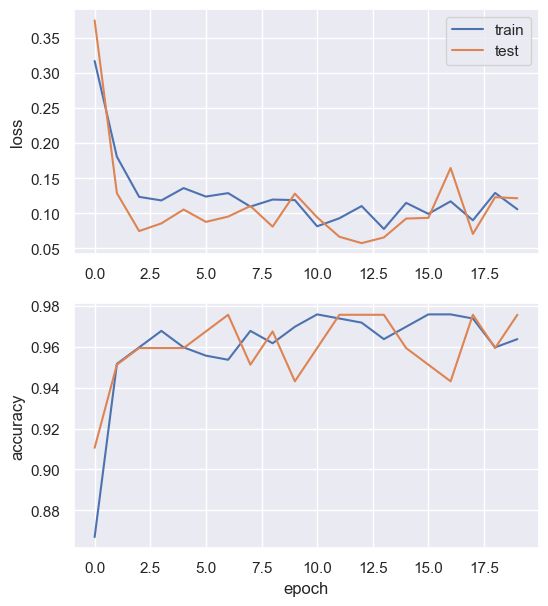

In [124]:
plot_train_test(train_losses, train_accuracy, test_losses, test_accuracy)  # noqa

In [125]:
y_true, y_pred = get_y_true_y_pred(net, test_dataloader, DEVICE)
y_true, y_pred = y_true.cpu(), y_pred.argmax(1).cpu()

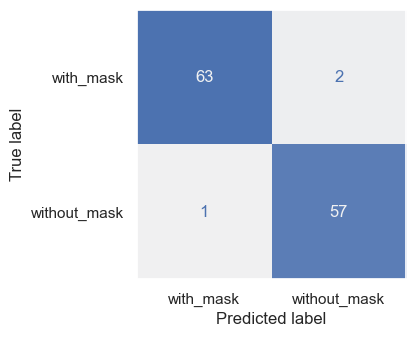

In [126]:
cm_display = metrics.ConfusionMatrixDisplay.from_predictions(
    y_true,
    y_pred,
    display_labels=masks_dataset.classes,
    colorbar=False,
    xticks_rotation=0,
    cmap=sns.color_palette('light:b', as_cmap=True)
)
cm_display.ax_.grid(False)
cm_display.figure_.set_size_inches(3.5, 3.5)

In [127]:
print(metrics.classification_report(y_true, y_pred, target_names=masks_dataset.classes, zero_division=True))

              precision    recall  f1-score   support

   with_mask       0.98      0.97      0.98        65
without_mask       0.97      0.98      0.97        58

    accuracy                           0.98       123
   macro avg       0.98      0.98      0.98       123
weighted avg       0.98      0.98      0.98       123



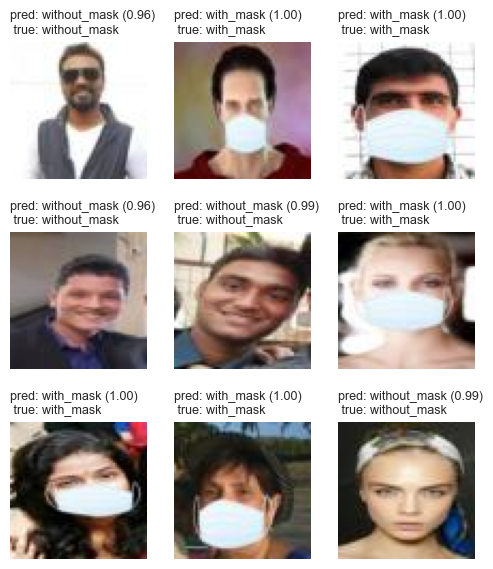

In [128]:
net.eval()

fig, axes = plt.subplots(3, 3, figsize=(6, 7))
for i, ax in zip(torch.randperm(len(test_dataset)), axes.flatten()):
    img, _ = masks_dataset[test_dataset.indices[i]]  # картинка до нормализации

    x, target = test_dataset[i]
    pred = net(x.unsqueeze(0).to(DEVICE))

    pred_proba = torch.max(torch.softmax(pred, 1))
    pred_label = pred.argmax(1).item()
    ax.set_title(
        f"pred: {masks_dataset.classes[pred_label]} ({pred_proba:.2f})"
        f"\n true: {masks_dataset.classes[target]}",
        loc="left",
        fontdict={"fontsize": 9},
    )
    ax.axis("off")
    if img.mode == "RGB":
        ax.imshow(img)
    else:
        ax.imshow(img, cmap="gray")